In [6]:
# System imports
import os 
import sys

# Numerical imports
import numpy as np
import pandas as pd
from scipy import stats

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, output_file, output_notebook, show, ColumnDataSource
from bokeh.models.tools import HoverTool

# Personal imports
from utils import output_dir

# Set the matplotlib/seaborn backend theme
sns.set()

DATASETS_PATH = os.path.join(os.getcwd(), "datasets")
RESSOURCES_PATH = os.path.join(os.getcwd(), "ressources")
HTML_PATH = os.path.join(RESSOURCES_PATH, "html")
CSV_PATH = os.path.join(RESSOURCES_PATH, "csv")
IMAGES_PATH = os.path.join(RESSOURCES_PATH, "images")
PLOTS_PATH = os.path.join(RESSOURCES_PATH, "plots")

Useful functions
---

In [7]:
class AttributeDict(dict):
    """
        Same as dict except that key/value pair can be access and set as attribute/value 
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


def plot(title, xs, lines, legends, x_label, y_label):
    p = figure(title=title, tools='', background_fill_color="#fafafa")
    if lines.ndim == 1:
        xs = np.expand_dims(xs, axis=0)
        lines = np.expand_dims(lines, axis=0)
        legends = np.expand_dims(legends, axis=0)
    
    for x, line, legend in zip(xs, lines, legends):
        p.line(x, line, alpha=.75, legend_label=legend)
    
    p.xaxis.axis_label = x_label
    p.yaxis.axis_label = y_label
    return p

def heatmap(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)


def bar(x_values, columns, title, figsize=(15,15), ax=None):
    args_sorted = np.argsort(x_values)[::-1]

    fig = plt.figure(figsize=(figsize))
    ax = ax or plt.gca()
    ax.set_title(title)
    col = columns[args_sorted]
    val = x_values[args_sorted]
    out = sns.barplot(y=col, x=val, palette = "viridis", ax=ax)
    return out


def plot_sfs(sfs, title, with_df=False, taken_slice=None):
    metric_df = pd.DataFrame(sfs.get_metric_dict()).T
    metric_df.drop("cv_scores", axis=1, inplace=True)

    if taken_slice is not None:
        metric_df = metric_df.iloc[taken_slice]
    
    p = figure(title=title, toolbar_location="above")
    source = ColumnDataSource(metric_df)
    p.line(x="index", y="avg_score", line_color="#FF00FF", line_alpha=.6, line_width=6,source=source)
    p.dot(x="index", y="avg_score", size=24, fill_color = "yellow", source=source) 

    p.add_tools(
        HoverTool(
            tooltips=[
                ("value","@avg_score"),
                ("n_features","@index"),
                #("","@feature_names")
            ],
        )
    )

    if with_df:
        return p, metric_df

    return p


Get the dataset in a DataFrame
---

Then we will drop useless columns:
- `is_weekend` column contains the information from the different columns `weekday_is_monday`, `weekday_is_tuesday`, ...

And we will merge several categorical columns into one class column:
- columns `weekday_is_monday`, `weekday_is_tuesday`, ... will be merged into a single `day` class column  

In [8]:
dataset = AttributeDict(
    train=AttributeDict(
        X=pd.read_csv(os.path.join(DATASETS_PATH, 'X1.csv')),
        y=pd.read_csv(os.path.join(DATASETS_PATH, 'Y1.csv'), header=None)
        ),
    test=AttributeDict(
        X=pd.read_csv(os.path.join(DATASETS_PATH, 'X2.csv')),
        y=None
    )
)
ALL_COLUMNS = dataset.train.X.columns

In [9]:
COLUMNS_TO_DROP = ["is_weekend"]
COLUMNS_TO_MERGE = {
    "day" : ["weekday_is_monday", "weekday_is_tuesday", "weekday_is_wednesday", "weekday_is_thursday", "weekday_is_friday", "weekday_is_saturday", "weekday_is_sunday"]
}

def drop_columns(df, columns):
    return df.drop(columns, axis=1)

def from_categorical_to_class(df, columns_dict, ):
    out_df = df.copy()
    def from_categorical(values):
        bool_values = values == 1
        return np.argwhere(bool_values)[:,1]

    for key, columns in COLUMNS_TO_MERGE.items():
        out_df[key] = from_categorical(df[columns].values)
        out_df.drop(columns, axis=1, inplace=True)
    
    return out_df

#for key in ("train", "test"):
#    df = dataset[key].X
#    df = drop_columns(df, COLUMNS_TO_DROP)
#    df = from_categorical_to_class(df, COLUMNS_TO_MERGE)
#    dataset[key].X = df

Set the type of data for each column between *numerical*, *categorical*, ...
---

In [10]:
CATEGORICAL_FEATURES = ["data_channel_is_lifestyle",
                        "data_channel_is_entertainment",
                        "data_channel_is_bus",
                        "data_channel_is_socmed",
                        "data_channel_is_tech",
                        "data_channel_is_world",
                        "weekday_is_monday",
                        "weekday_is_tuesday",
                        "weekday_is_wednesday",
                        "weekday_is_thursday",
                        "weekday_is_friday",
                        "weekday_is_saturday",
                        "weekday_is_sunday",
                        "is_weekend"]

def change_type(df, categorical_features):
    for cat_col in categorical_features:
        df[cat_col] = pd.Categorical(df[cat_col].values)
    return df

for key in ("train", "test"):
    dataset[key].X = change_type(dataset[key].X, CATEGORICAL_FEATURES)


Just show the data
---

In [6]:
m=dataset.train.y.values.min()
mi=dataset.train.y.values.max()
m,mi

(1, 843300)

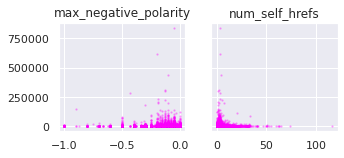

In [29]:
# TODO : categorical -> bins, numerical -> distribution
numerical_columns = list(set(ALL_COLUMNS) - set(CATEGORICAL_FEATURES))

globsize = 2.9
fig, *axis = plt.subplots(nrows=1, ncols=2, figsize=(int(globsize*2),int(globsize*1)), sharey=True)
axis = np.array(axis).reshape(-1)

for ax, col in zip(axis, numerical_columns):
    ax.set_title(col)
    ax.scatter(dataset.train.X[col].values, dataset.train.y.values, color="#FF00FF", s=2, alpha=.25)

plt.show()

Mutual information
---

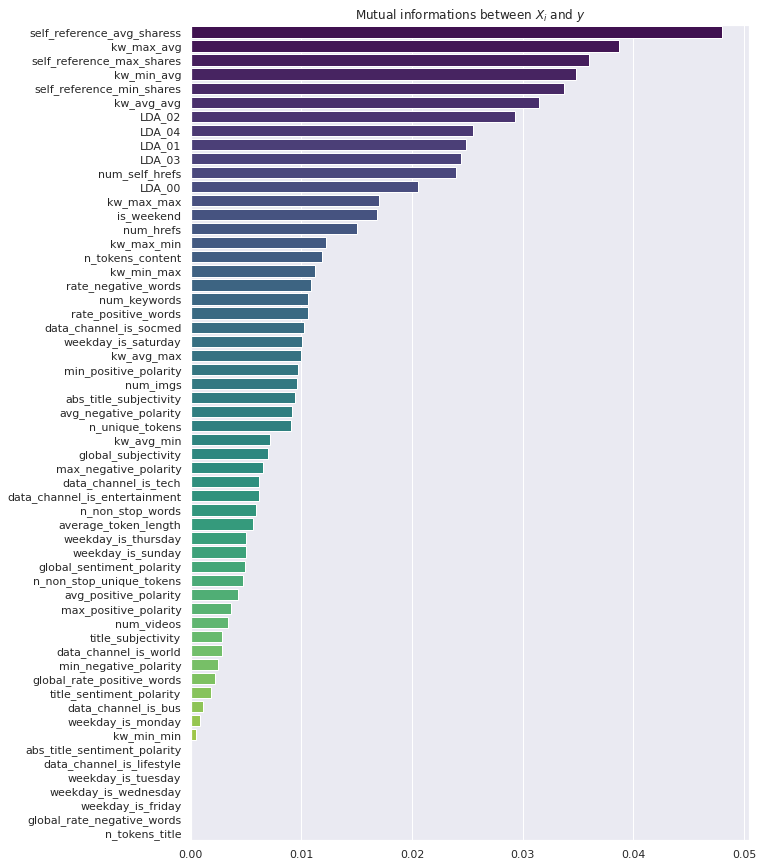

In [10]:
from sklearn.feature_selection import mutual_info_regression

mutual_infos = mutual_info_regression(dataset.train.X.values, dataset.train.y.values)

out = bar(mutual_infos, dataset.train.X.columns.values, "Mutual informations between $X_i$ and $y$", (10,15))

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

#k_best = SelectKBest(score_func=mutual_info_regression)

#k_best.fit(dataset.train.X.values, dataset.train.y.values)

#bar(k_best.scores_, dataset.train.X.columns.values, "")

In [ ]:
from sklearn.feature_selection import from_model


Forward selection
---

In [ ]:
import sklearn

In [7]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.datasets import load_boston

boston = load_boston()
X, y = boston.data, boston.target

lr = Lasso()

n_columns = len(dataset.train.X.columns)
sfs = SFS(lr,
          k_features=n_columns,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 10,
          n_jobs=-1)

sfs.fit(dataset.train.X,dataset.train.y)

sfs_type = "forward"
title="Sequential feature selector : %s"%sfs_type

p, metric_df = plot_sfs(
    sfs, 
    title=title,
    with_df=True, 
    taken_slice=slice(-1))

with output_dir(os.path.join(HTML_PATH, "sfs")) as path:
    output_file(
        os.path.join(path, sfs_type),
        title=title)
with output_dir(os.path.join(CSV_PATH, "sfs")) as path:
    metric_df.to_csv(os.path.join(path, "%s.csv"%sfs_type), sep="\t")
output_notebook()
show(p)


Loading BokehJS ...

In [ ]:
lr = LinearRegression()

n_columns = len(dataset.train.X.columns)
sfs = SFS(lr,
          k_features=2,
          forward=False,
          floating=False,
          scoring = 'r2',
          cv = 10,
          n_jobs=-1)

sfs.fit(dataset.train.X,dataset.train.y)

sfs_type = "backward"
title="Sequential feature selector : %s"%sfs_type
taken_slice = slice(1,-1)
p, metric_df = plot_sfs(
    sfs, 
    title=title,
    with_df=True,
    taken_slice=taken_slice)

with output_dir(os.path.join(HTML_PATH, "sfs")) as path:
    output_file(
        os.path.join(path, sfs_type),
        title=title)

with output_dir(os.path.join(CSV_PATH, "sfs")) as path:
    metric_df.to_csv(os.path.join(path, "%s.csv"%sfs_type), sep="\t")

output_notebook()
show(p)

